In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
import PIL
from PIL import Image
from tqdm import tqdm  

In [31]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

In [32]:
from torchvision import datasets, transforms, models

In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

In [34]:
from google.colab import drive 

In [35]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/dataset'

In [37]:
labels = os.listdir(data_dir)

In [38]:
for i in labels:
  l = os.listdir(data_dir+'/'+i)
  print(i, len(l))

vasisthasana 74
virabhadrasana ii 56
vajrasana 54
virasana 50
viparita karani 69
vrischikasana 51
yoganidrasana 46
vriksasana 62
virabhadrasana i 55
virabhadrasana iii 61
urdhva prasarita eka padasana 53
uttanasana 63
utthita ashwa sanchalanasana 38
ustrasana 87
utkatasana 73
utthita hasta padangustasana 59
urdhva mukha svanasana 63
uttana shishosana 50
utthita trikonasana 69
utthita parsvakonasana 63
supta matsyendrasana 54
tulasana 31
urdhva dhanurasana 68
supta padangusthasana 62
upavistha konasana 60
tolasana 60
tittibhasana 57
urdhva hastasana 47
tadasana 56
supta virasana 60
salamba bhujangasana 55
salamba sirsasana 60
setu bandha sarvangasana 58
purvottanasana 63
supta baddha konasana 71
sukhasana 50
salamba sarvangasana 67
savasana 57
salabhasana 58
simhasana 49
pasasana 56
pincha mayurasana 35
parivrtta trikonasana 62
parsvottanasana 35
parsva bakasana 56
prasarita padottanasana 66
paschimottanasana 56
phalakasana 57
parivrtta parsvakonasana 40
parivrtta janu sirsasana 39
marj

DATA AUGMENTATION

In [39]:
num_classes=len(labels)
num_classes


107

In [40]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), 
                                      transforms.RandomCrop(224),
                                     transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = ImageFolder(data_dir, transform = transformations)

In [41]:
dataset.class_to_idx 

{'adho mukha svanasana': 0,
 'adho mukha vriksasana': 1,
 'agnistambhasana': 2,
 'ananda balasana': 3,
 'anantasana': 4,
 'anjaneyasana': 5,
 'ardha bhekasana': 6,
 'ardha chandrasana': 7,
 'ardha matsyendrasana': 8,
 'ardha pincha mayurasana': 9,
 'ardha uttanasana': 10,
 'ashtanga namaskara': 11,
 'astavakrasana': 12,
 'baddha konasana': 13,
 'bakasana': 14,
 'balasana': 15,
 'bhairavasana': 16,
 'bharadvajasana i': 17,
 'bhekasana': 18,
 'bhujangasana': 19,
 'bhujapidasana': 20,
 'bitilasana': 21,
 'camatkarasana': 22,
 'chakravakasana': 23,
 'chaturanga dandasana': 24,
 'dandasana': 25,
 'dhanurasana': 26,
 'durvasasana': 27,
 'dwi pada viparita dandasana': 28,
 'eka pada koundinyanasana i': 29,
 'eka pada koundinyanasana ii': 30,
 'eka pada rajakapotasana': 31,
 'eka pada rajakapotasana ii': 32,
 'ganda bherundasana': 33,
 'garbha pindasana': 34,
 'garudasana': 35,
 'gomukhasana': 36,
 'halasana': 37,
 'hanumanasana': 38,
 'janu sirsasana': 39,
 'kapotasana': 40,
 'krounchasana': 

In [42]:
targets = dataset.targets
len(targets)

5991

Train - TEST split

In [43]:
from sklearn.model_selection import train_test_split
train_idx, test_idx= train_test_split(np.arange(len(targets)),test_size=0.20,shuffle=True,stratify=targets) 

In [44]:
trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=train_idx)   
testloader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=test_idx) 

In [46]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
print(images[1].shape)
print(labels[1].item())

torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
42


EFFICIENT NET

In [47]:
pip install efficientnet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
from efficientnet_pytorch import EfficientNet
effNet = EfficientNet.from_pretrained('efficientnet-b0') 

Loaded pretrained weights for efficientnet-b0


In [49]:
effNet._fc

Linear(in_features=1280, out_features=1000, bias=True)

In [50]:
import torch.nn as nn

class EfficientNet_b0(nn.Module):
    def __init__(self):
        super(EfficientNet_b0, self).__init__()
        self.model =EfficientNet.from_pretrained('efficientnet-b0')       # Give variant as per requirement
        
        self.model._fc = nn.Sequential(
            nn.Linear(self.model._fc.in_features, 107),
            nn.LogSoftmax()                                               # Required if training with NLLLoss
        )
        
    def forward(self, x):
        out = self.model(x)
        return out

In [51]:
effNet = EfficientNet_b0()

Loaded pretrained weights for efficientnet-b0


In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [53]:
torch.cuda.is_available()

True

In [54]:
effNet = effNet.to('cuda')

In [55]:
optimizer = optim.Adadelta(effNet.parameters())     # Defining the optimiser.
loss_func = nn.NLLLoss()                            # Defining the loss function
                                                    # Vary optimiser and loss function as per requirement while training.

In [56]:
train_losses = []
train_acc = []
test_losses = []
test_acc = []
for epoch in range(7):   # Run for loop for number of times. The number of times is the epochs
    train_correct = 0
    total1 = 0
    running_loss = 0
    with tqdm(trainloader, unit="batch") as tepoch:
        for images, labels in tepoch:                               # Training the dataset
            tepoch.set_description(f"Training : Epoch {epoch+1}")
            images, labels = images.cuda(), labels.cuda()
            labels = labels.long()
            optimizer.zero_grad()
            outputs = effNet(images) 
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total1 += labels.size(0)

            if torch.cuda.is_available():
                train_correct += (predicted.cpu() == labels.cpu()).sum().item()
                traincorrect = (predicted.cpu() == labels.cpu()).sum().item()
            else:
                train_correct += (predicted == labels).sum().item()
                traincorrect = (predicted == labels).sum().item()
            tepoch.set_postfix(loss=loss.item(), accuracy=100* (traincorrect/32.0))

    train_accuracy = 100 * train_correct / total1
    train_loss = running_loss/len(trainloader)
    train_acc.append(train_accuracy)
    train_losses.append(train_loss)


    test_loss = 0
    correct = 0
    total = 0
    pred = []
    test = []
    with tqdm(testloader, unit="batch") as tstepoch:      
        for images, labels in tstepoch:                       
           for images, labels in tstepoch:                                       # Testing 
            tstepoch.set_description(f"Testing : Epoch {epoch+1}")
            images, labels = images.cuda(), labels.cuda()
            labels = labels.long() 
            outputs = effNet(images)
            loss_t = loss_func(outputs, labels)
            test_loss += loss_t.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            if torch.cuda.is_available():
                correct += (predicted.cpu() == labels.cpu()).sum().item()
                tstcorrect = (predicted.cpu() == labels.cpu()).sum().item()
            else:
                correct += (predicted == labels).sum().item()
                tstcorrect = (predicted == labels).sum().item()
            tstepoch.set_postfix(loss=loss_t.item(), accuracy=100*(tstcorrect/32.0))
 
    test_loss=test_loss/len(testloader)
    accuracy = 100 * correct / total
    test_acc.append(accuracy)
    test_losses.append(test_loss)
    print('\nEpoch: {} - loss: {} - accuracy: {} - val_Loss: {} - val_accuracy: {}\n'.format(epoch+1, train_loss, train_accuracy, test_loss, accuracy))


Testing : Epoch 1: 100%|██████████| 38/38 [03:20<00:00,  5.28s/batch, accuracy=25, loss=2]



Epoch: 1 - loss: 2.559454309940338 - accuracy: 37.91736227045075 - val_Loss: 59.485000108417715 - val_accuracy: 57.0694877310039



Testing : Epoch 2: 100%|██████████| 38/38 [00:14<00:00,  2.67batch/s, accuracy=31.2, loss=1.78]



Epoch: 2 - loss: 1.0683861291408538 - accuracy: 68.3848080133556 - val_Loss: 46.67948169849421 - val_accuracy: 66.59935911505201



Testing : Epoch 3: 100%|██████████| 38/38 [00:14<00:00,  2.70batch/s, accuracy=31.2, loss=1.93]



Epoch: 3 - loss: 0.6324161803722381 - accuracy: 80.48831385642738 - val_Loss: 46.43326285481453 - val_accuracy: 68.06549317413634



Testing : Epoch 4: 100%|██████████| 38/38 [00:14<00:00,  2.63batch/s, accuracy=31.2, loss=2.5]



Epoch: 4 - loss: 0.4150603645046552 - accuracy: 86.91569282136895 - val_Loss: 49.47851241027054 - val_accuracy: 66.55326807427242



Testing : Epoch 5: 100%|██████████| 38/38 [00:14<00:00,  2.71batch/s, accuracy=37.5, loss=1.99]



Epoch: 5 - loss: 0.3123098735014598 - accuracy: 90.08764607679466 - val_Loss: 51.07510581142024 - val_accuracy: 67.94038892059172



Testing : Epoch 6: 100%|██████████| 38/38 [00:14<00:00,  2.70batch/s, accuracy=28.1, loss=3.24]



Epoch: 6 - loss: 0.24583314095934233 - accuracy: 91.9449081803005 - val_Loss: 51.176760781752435 - val_accuracy: 68.4012993283877



Testing : Epoch 7: 100%|██████████| 38/38 [00:14<00:00,  2.69batch/s, accuracy=37.5, loss=2.01]



Epoch: 7 - loss: 0.20061387157688537 - accuracy: 93.73956594323873 - val_Loss: 55.12400253587648 - val_accuracy: 67.43997190641323



In [62]:
torch.save(effNet,'model-68.40-ADADELTA-NNLoss-aug')

In [66]:
model = torch.load('/content/model-68.40-ADADELTA-NNLoss-aug')


In [67]:
pred = []
test = []
for images, labels in tqdm(testloader):
        images, labels = images.cuda(), labels.cuda()
        test.extend(labels)
        labels = labels.long() 
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        pred.extend(predicted)

100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


In [68]:
predicted = []
tester = []
for i in pred:
    predicted.append(i.cpu().detach().numpy())
for i in test:
    tester.append(i.cpu().detach().numpy())
np_pred = np.array(predicted)
np_test = np.array(tester)

<Axes: xlabel='Predicted', ylabel='Actual'>

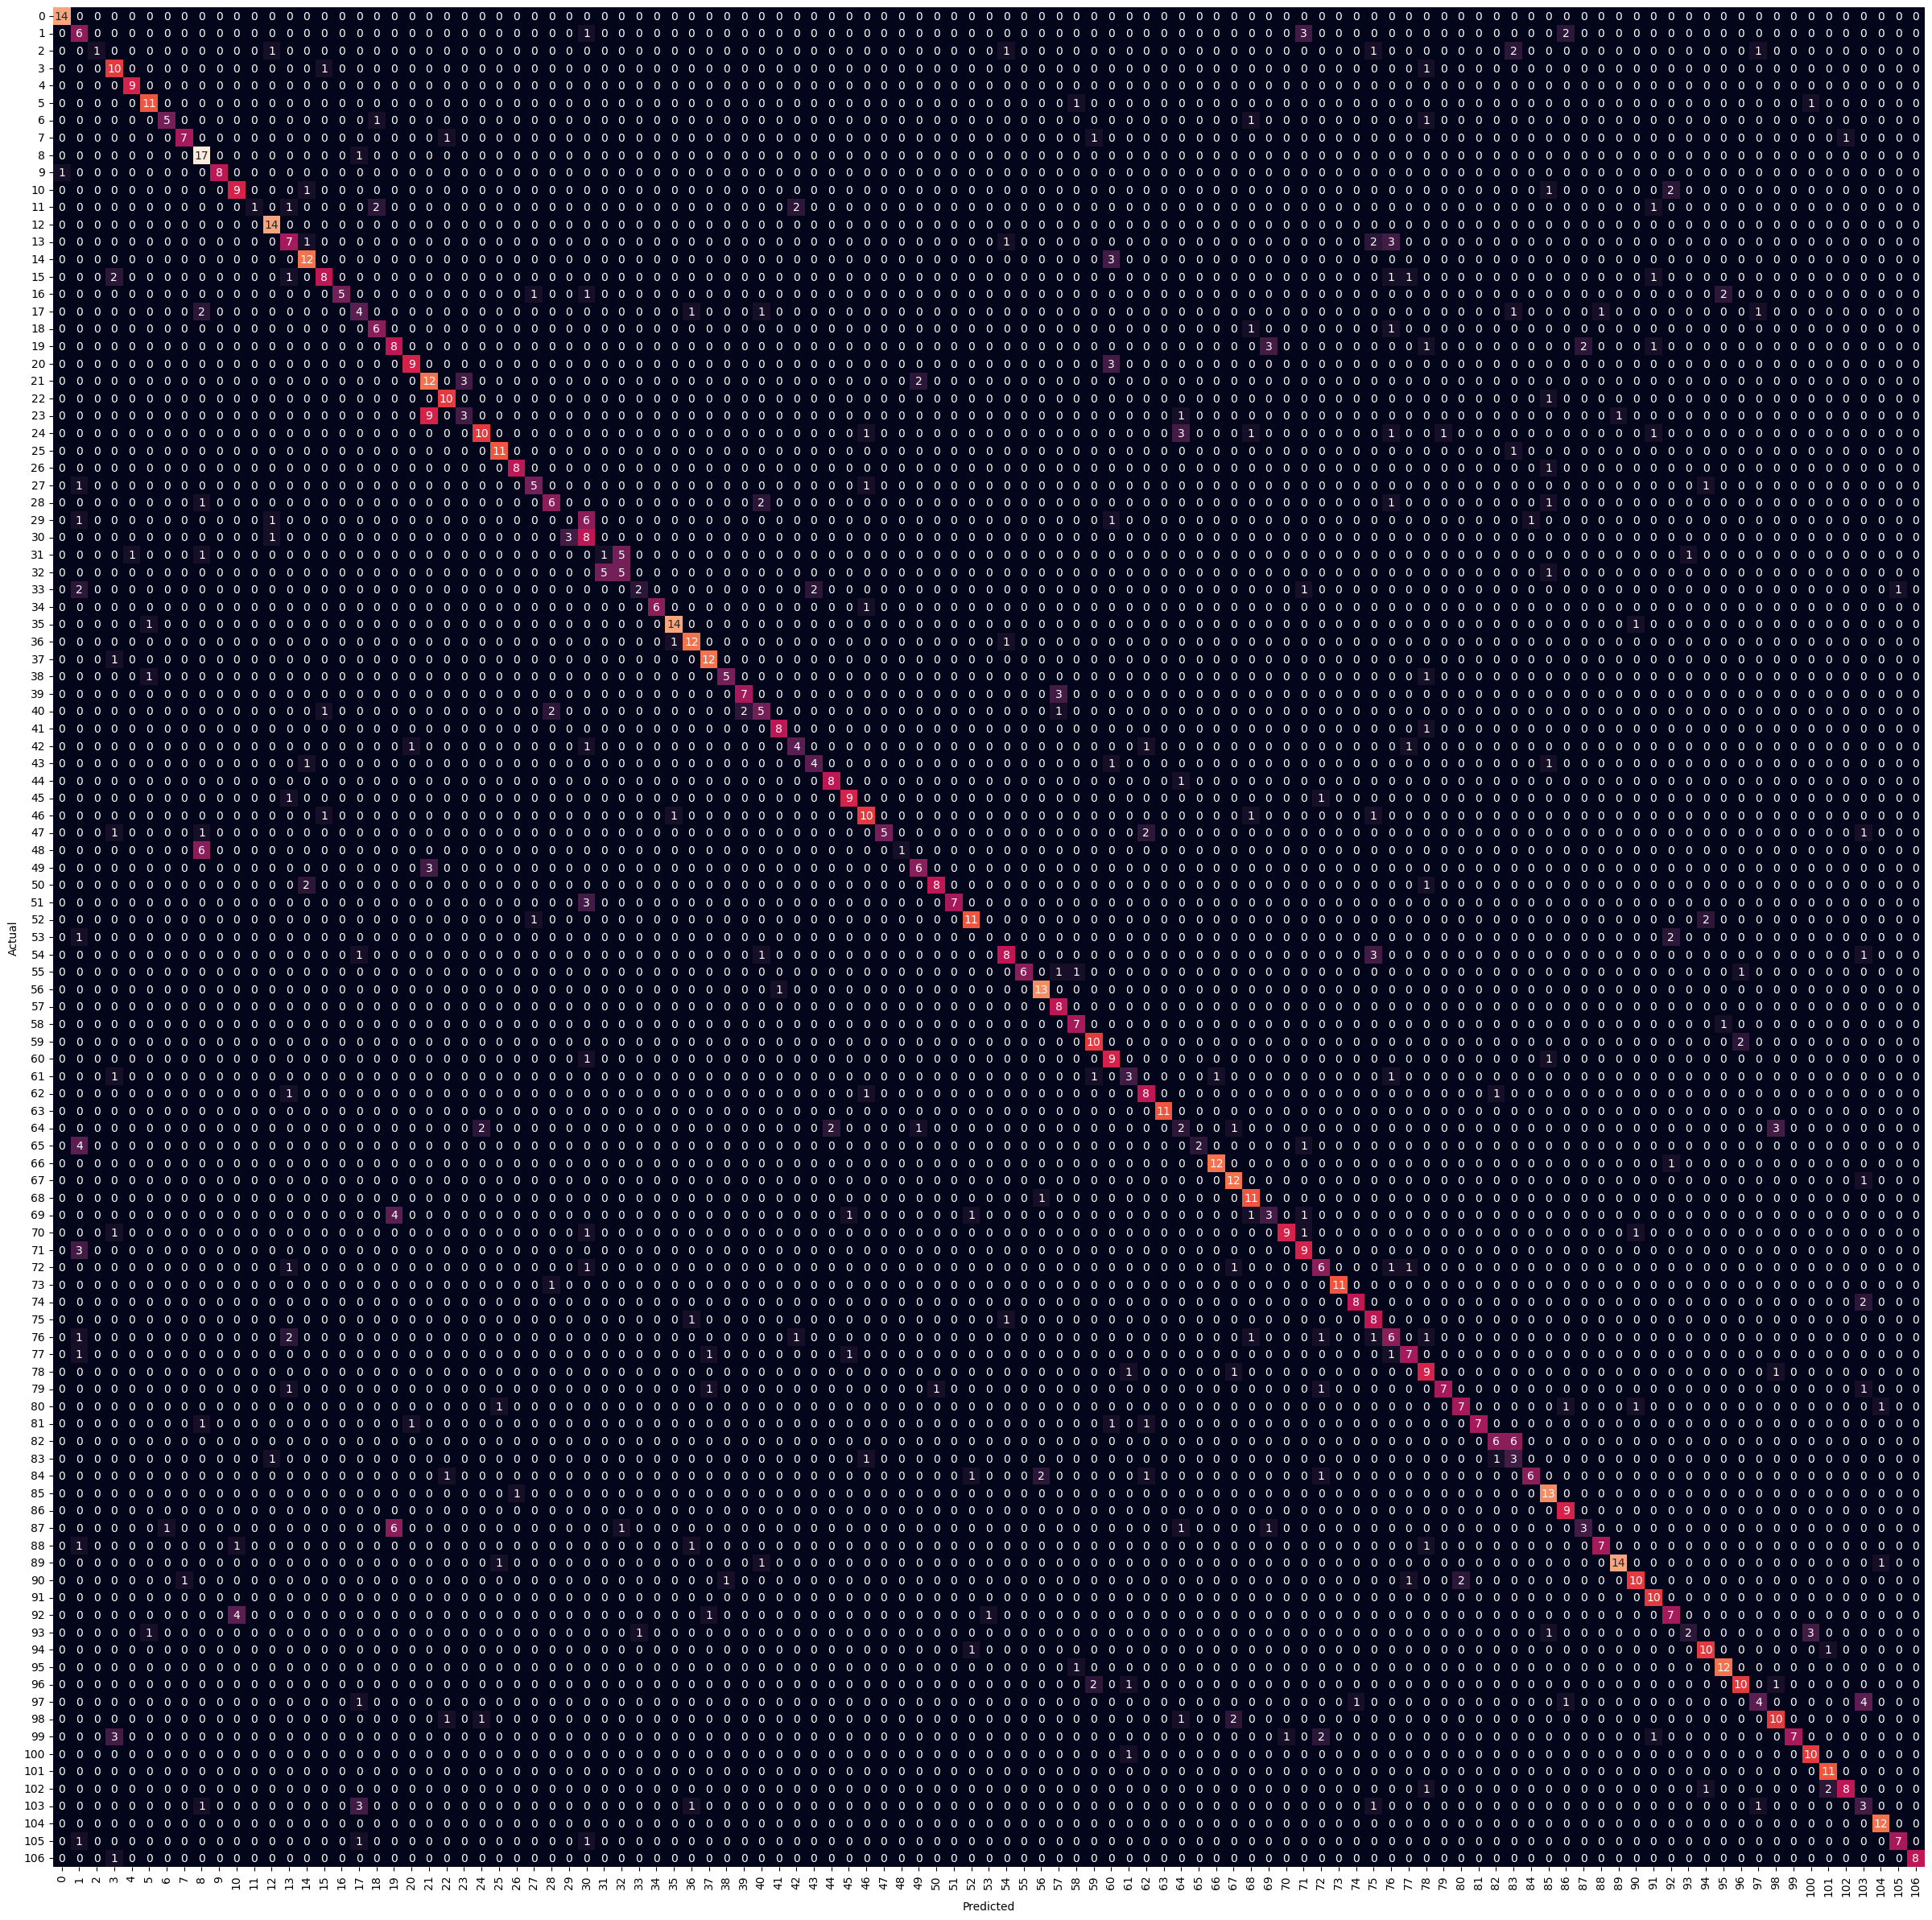

In [69]:
import seaborn as sns
cm = confusion_matrix(np_test, np_pred)
df_cm = pd.DataFrame(cm)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (30,30))
sns.heatmap(df_cm, annot = True, fmt='d', cbar=False)

In [70]:
classes = dataset.class_to_idx
  
new_dict = dict([(value, key) for key, value in classes.items()])
new_dict


{0: 'adho mukha svanasana',
 1: 'adho mukha vriksasana',
 2: 'agnistambhasana',
 3: 'ananda balasana',
 4: 'anantasana',
 5: 'anjaneyasana',
 6: 'ardha bhekasana',
 7: 'ardha chandrasana',
 8: 'ardha matsyendrasana',
 9: 'ardha pincha mayurasana',
 10: 'ardha uttanasana',
 11: 'ashtanga namaskara',
 12: 'astavakrasana',
 13: 'baddha konasana',
 14: 'bakasana',
 15: 'balasana',
 16: 'bhairavasana',
 17: 'bharadvajasana i',
 18: 'bhekasana',
 19: 'bhujangasana',
 20: 'bhujapidasana',
 21: 'bitilasana',
 22: 'camatkarasana',
 23: 'chakravakasana',
 24: 'chaturanga dandasana',
 25: 'dandasana',
 26: 'dhanurasana',
 27: 'durvasasana',
 28: 'dwi pada viparita dandasana',
 29: 'eka pada koundinyanasana i',
 30: 'eka pada koundinyanasana ii',
 31: 'eka pada rajakapotasana',
 32: 'eka pada rajakapotasana ii',
 33: 'ganda bherundasana',
 34: 'garbha pindasana',
 35: 'garudasana',
 36: 'gomukhasana',
 37: 'halasana',
 38: 'hanumanasana',
 39: 'janu sirsasana',
 40: 'kapotasana',
 41: 'krounchasan

In [71]:
print(classification_report(np_test,np_pred))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       0.27      0.50      0.35        12
           2       1.00      0.14      0.25         7
           3       0.50      0.83      0.62        12
           4       0.90      1.00      0.95         9
           5       0.79      0.85      0.81        13
           6       0.83      0.62      0.71         8
           7       0.88      0.70      0.78        10
           8       0.57      0.94      0.71        18
           9       1.00      0.89      0.94         9
          10       0.64      0.69      0.67        13
          11       1.00      0.14      0.25         7
          12       0.78      1.00      0.88        14
          13       0.47      0.50      0.48        14
          14       0.71      0.80      0.75        15
          15       0.73      0.57      0.64        14
          16       1.00      0.56      0.71         9
          17       0.36    

In [72]:
cl = classification_report(np_test,np_pred, output_dict=True)
df = pd.DataFrame(cl).transpose()
df = df.iloc[:-3,]
df.index = dataset.classes
df

,precision,recall,f1-score,support
adho mukha svanasana,0.933333,1.000000,0.965517,14.0
adho mukha vriksasana,0.272727,0.500000,0.352941,12.0
agnistambhasana,1.000000,0.142857,0.250000,7.0
ananda balasana,0.500000,0.833333,0.625000,12.0
anantasana,0.900000,1.000000,0.947368,9.0
...,...,...,...,...
virabhadrasana iii,0.888889,0.666667,0.761905,12.0
virasana,0.230769,0.300000,0.260870,10.0
vriksasana,0.857143,1.000000,0.923077,12.0
vrischikasana,0.875000,0.700000,0.777778,10.0


In [73]:

df.sort_values(by='f1-score', ascending=False)[:10].iloc[:,2].index

Index(['paschimottanasana', 'adho mukha svanasana', 'setu bandha sarvangasana',
       'anantasana', 'ardha pincha mayurasana', 'yoganidrasana',
       'prasarita padottanasana', 'vriksasana', 'garbha pindasana',
       'krounchasana'],
      dtype='object')

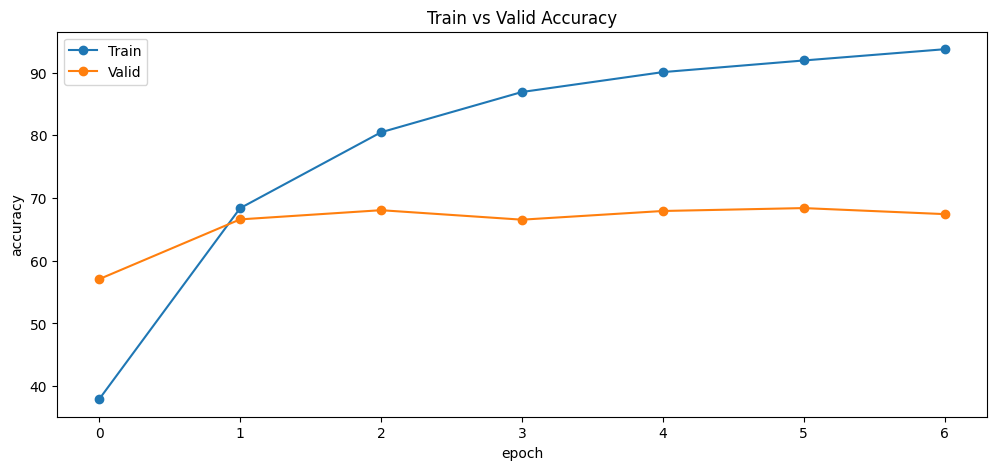

In [74]:
fig = plt.figure(figsize=(12,5))
plt.plot(train_acc,'-o')
plt.plot(test_acc,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.show()

In [75]:
cl = classification_report(np_test,np_pred, output_dict=True)
df = pd.DataFrame(cl).transpose()
df = df.iloc[:-3,]
df.index = dataset.classes
df

,precision,recall,f1-score,support
adho mukha svanasana,0.933333,1.000000,0.965517,14.0
adho mukha vriksasana,0.272727,0.500000,0.352941,12.0
agnistambhasana,1.000000,0.142857,0.250000,7.0
ananda balasana,0.500000,0.833333,0.625000,12.0
anantasana,0.900000,1.000000,0.947368,9.0
...,...,...,...,...
virabhadrasana iii,0.888889,0.666667,0.761905,12.0
virasana,0.230769,0.300000,0.260870,10.0
vriksasana,0.857143,1.000000,0.923077,12.0
vrischikasana,0.875000,0.700000,0.777778,10.0


In [76]:
aa = df.sort_values(by='f1-score', ascending=False)[:10]
bb = df.sort_values(by='f1-score', ascending=True)[:10]
cc = pd.concat([aa,bb])
cc = cc.sort_values(by='f1-score', ascending=True)[:20]
cc

,precision,recall,f1-score,support
eka pada koundinyanasana i,0.000000,0.000000,0.000000,10.0
padangusthasana,0.000000,0.000000,0.000000,3.0
eka pada rajakapotasana,0.166667,0.111111,0.133333,9.0
phalakasana,0.222222,0.181818,0.200000,11.0
ashtanga namaskara,1.000000,0.142857,0.250000,7.0
marichyasana iii,1.000000,0.142857,0.250000,7.0
agnistambhasana,1.000000,0.142857,0.250000,7.0
virasana,0.230769,0.300000,0.260870,10.0
chakravakasana,0.500000,0.214286,0.300000,14.0
tulasana,0.230769,0.500000,0.315789,6.0


<Axes: xlabel='f1-score'>

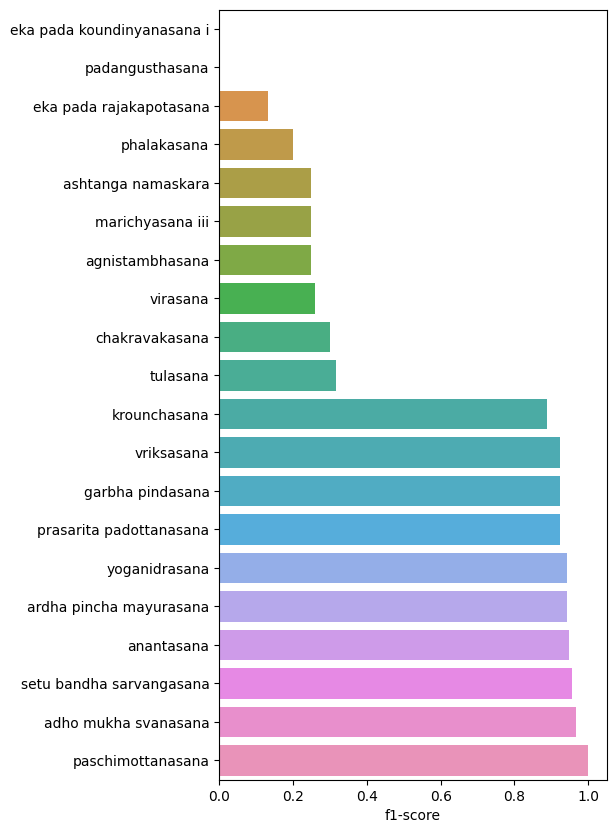

In [77]:
fig = plt.figure(figsize=(5,10))
sns.barplot(y = cc.index, x=cc['f1-score'])

In [78]:
fig.savefig("F1.pdf")

In [79]:
img = Image.open('/content/vrikshasan.jpg')

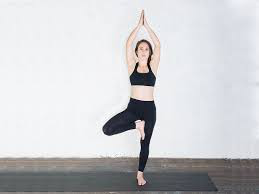

In [80]:
img

In [85]:
def predict(img):
    img = transformations(img)
    img = img.unsqueeze(0)
    outputs = model(img.to("cuda"))
    _, predicted = torch.max(outputs.data, 1)
    return dataset.classes[predicted]

print("The predicted yogasana : ", predict(img))

The predicted yogasana :  vriksasana
